### ------------- Applied Data Science Capstone -------------
# Analyzing Neighborhoods of Toronto to Starting A New Restaurant

In [148]:
import requests
import pandas as pd
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import numpy as np 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
import requests 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 

### Scrap Neighborhoods of Toronto Data

In [3]:
#scrape data from webpage
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(url)

soup = bs(page.text, 'lxml')
table_elements = soup.find('table', class_='wikitable sortable')


In [4]:
#create list to store data from webpage
table_data = []
table_header = []

for id, tr in enumerate(table_elements.find_all('tr')):
    part = []
    for td in tr.find_all(['td', 'th']):  #get data per row
        part.append(td.text.strip())
    if not table_header:                  #find table header
        table_header = part  
    else:
        table_data.append(part)
    

In [7]:
#store data in a dataframe
df_postal = pd.DataFrame(data = table_data, columns = table_header)
col_name = {'Postal Code': 'PostalCode', 'Neighbourhood' : 'Neighborhood'}
df_postal = df_postal.rename(columns=col_name)


In [9]:
#Only process the cells that have an assigned borough
df_postal = df_postal[df_postal['Borough'] != 'Not assigned'].reset_index(drop=True)
df_postal.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [8]:
print('Number of rows    : ', df_postal.shape[0])
print('Number of columns : ', df_postal.shape[1])

Number of rows    :  180
Number of columns :  3


### Get geographical coordinates of the neighborhoods data

In [22]:
df_geo = pd.read_csv('Geospatial_Coordinates.csv')
col_name = {'Postal Code': 'PostalCode'}
df_geo = df_geo.rename(columns=col_name)

#df_geo.head()

In [12]:
#merge table (df_postal and df_geo)
df_merge = pd.merge(df_postal, df_geo)
df_merge.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### Narrow down boroughs

In [25]:
#work with only boroughs that contain word 'Toronto'
df_toronto = df_merge[df_merge['Borough'].str.contains('Toronto')].reset_index(drop=True)
print("List of boroughs : ", df_toronto['Borough'].unique())
df_toronto.shape

List of boroughs :  ['Downtown Toronto' 'East Toronto' 'West Toronto' 'Central Toronto']


(39, 5)

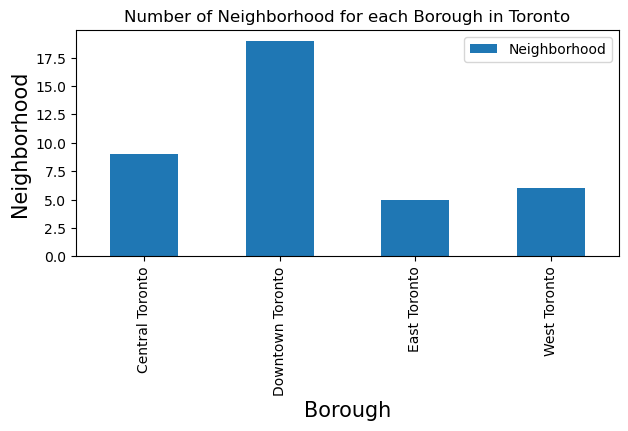

In [154]:
#NUMBER OF NEIGHBORHOODS FOR EACH BOROUGHS
#From the below Bar Plot, we can see that Downtown Toronto has highest number of neighborhoods

plt.figure(figsize=(7,3), dpi = 100)
plt.title('Number of Neighborhood for each Borough in Toronto')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Neighborhood', fontsize=15)

df_toronto.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

### Create a map of Toronto with neighborhoods superimposed on top.

In [157]:
# create map of Toronto with neighborhoods superimposed on top
map_toronto = folium.Map(location=[df_toronto['Latitude'][0], df_toronto['Longitude'][0]], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Get Venue Data

In [26]:
CLIENT_ID = '31TEC4G1QQODP2PFJ2YTFZ2YSRZ000QUTKZR5NLW5SRJDWDS' 
CLIENT_SECRET = 'KQAA5EN1Z0OHHLN4MKM02KFH1PROBM2V3CTJKHJKEA21TDPO' 
ACCESS_TOKEN = '2HAB2F4SH3ELF3ZFHHZMCPEZJJFUJCWKL54P5SKKNR2GSVHG' 
VERSION = '20180604'
LIMIT = 100

In [27]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

In [26]:
#list all near vanues, group by neighborhood
print(toronto_venues.shape)
toronto_venues.head(10)

(1630, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
5,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
6,"Regent Park, Harbourfront",43.65426,-79.360636,The Extension Room,43.653313,-79.359725,Gym / Fitness Center
7,"Regent Park, Harbourfront",43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park
8,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site
9,"Regent Park, Harbourfront",43.65426,-79.360636,SOMA chocolatemaker,43.650622,-79.358127,Chocolate Shop


In [33]:
print("Number of venues for each neighborhoods : ")
toronto_venues.groupby('Neighborhood').count()

Number of venues in neighborhoods : 


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",15,15,15,15,15,15
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,66,66,66,66,66,66
Christie,16,16,16,16,16,16
Church and Wellesley,79,79,79,79,79,79
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,35,35,35,35,35,35


In [158]:
neigh_count = len(toronto_venues['Neighborhood'].unique())
ven_category = toronto_venues['Venue Category'].unique()
ven_count = len(ven_category)

res_category = [s for s in ven_category if "Restaurant" in s]
res_count = len(res_category)
res_all = len(toronto_venues['Venue Category']== (s for s in ven_category if "Restaurant" in s))

print('There are {} uniques venue categories in {} neighborhoods.'.format(ven_count, neigh_count))
print('Number of restaurant : ', res_all)
print('Number of restaurant category : ', res_count)
print(res_category)

There are 234 uniques venue categories in 39 neighborhoods.
Number of restaurant :  1620
Number of restaurant category :  44
['Restaurant', 'French Restaurant', 'Italian Restaurant', 'Portuguese Restaurant', 'Mexican Restaurant', 'Sushi Restaurant', 'Japanese Restaurant', 'Fast Food Restaurant', 'Ramen Restaurant', 'Thai Restaurant', 'Modern European Restaurant', 'Seafood Restaurant', 'Middle Eastern Restaurant', 'Ethiopian Restaurant', 'Chinese Restaurant', 'Vietnamese Restaurant', 'American Restaurant', 'New American Restaurant', 'Vegetarian / Vegan Restaurant', 'German Restaurant', 'Comfort Food Restaurant', 'Asian Restaurant', 'Belgian Restaurant', 'Moroccan Restaurant', 'Greek Restaurant', 'Eastern European Restaurant', 'Indian Restaurant', 'Falafel Restaurant', 'Korean Restaurant', 'Colombian Restaurant', 'Mediterranean Restaurant', 'Brazilian Restaurant', 'Gluten-free Restaurant', 'Latin American Restaurant', 'Cuban Restaurant', 'Tibetan Restaurant', 'Caribbean Restaurant', 'Caj

### Analyze each neighborhood

In [47]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

#toronto_onehot.head()
#toronto_onehot.shape

In [114]:
#frequency for all venue in toronto
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
#toronto_grouped

In [163]:
#dataframe with all restaurant in toronto (frequency)
toronto_rest = toronto_grouped[res_category]
toronto_rest = toronto_grouped[["Neighborhood"]].join(toronto_rest)
toronto_rest.head(50)

,Neighborhood,Restaurant,French Restaurant,Italian Restaurant,Portuguese Restaurant,Mexican Restaurant,Sushi Restaurant,Japanese Restaurant,Fast Food Restaurant,Ramen Restaurant,Thai Restaurant,Modern European Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Ethiopian Restaurant,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,New American Restaurant,Vegetarian / Vegan Restaurant,German Restaurant,Comfort Food Restaurant,Asian Restaurant,Belgian Restaurant,Moroccan Restaurant,Greek Restaurant,Eastern European Restaurant,Indian Restaurant,Falafel Restaurant,Korean Restaurant,Colombian Restaurant,Mediterranean Restaurant,Brazilian Restaurant,Gluten-free Restaurant,Latin American Restaurant,Cuban Restaurant,Tibetan Restaurant,Caribbean Restaurant,Cajun / Creole Restaurant,South American Restaurant,Filipino Restaurant,Doner Restaurant,Molecular Gastronomy Restaurant,Taiwanese Restaurant,Theme Restaurant
0,Berczy Park,0.034483,0.017241,0.000000,0.000000,0.000000,0.017241,0.017241,0.000000,0.000000,0.017241,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.017241,0.000000,0.000000,0.000000,0.017241,0.017241,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.045455,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Business reply mail Processing Centre, South C...",0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.015152,0.015152,0.060606,0.015152,0.000000,0.015152,0.015152,0.000000,0.015152,0.030303,0.015152,0.015152,0.015152,0.000000,0.000000,0.000000,0.000000,0.000000,0.015152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015152,0.015152,0.015152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Christie,0.062500,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.037975,0.000000,0.000000,0.000000,0.012658,0.063291,0.063291,0.037975,0.012658,0.012658,0.000000,0.000000,0.000000,0.012658,0.000000,0.012658,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658,0.000000,0.012658,0.000000,0.025316,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658
7,"Commerce Court, Victoria Hotel",0.070000,0.010000,0.040000,0.000000

In [123]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [162]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_rest['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_rest.iloc[ind, :], num_top_venues)

#most common venue in each neighborhoods
neighborhoods_venues_sorted.head(50)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Restaurant,Seafood Restaurant,French Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Greek Restaurant,Eastern European Restaurant,Indian Restaurant,Comfort Food Restaurant,Japanese Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Restaurant,Italian Restaurant,Seafood Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Ethiopian Restaurant
2,"Business reply mail Processing Centre, South C...",Restaurant,Fast Food Restaurant,Seafood Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Ethiopian Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",Theme Restaurant,Taiwanese Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Ethiopian Restaurant,Middle Eastern Restaurant
4,Central Bay Street,Italian Restaurant,Thai Restaurant,Restaurant,Ramen Restaurant,Indian Restaurant,Falafel Restaurant,Korean Restaurant,Middle Eastern Restaurant,Seafood Restaurant,Modern European Restaurant
5,Christie,Restaurant,Italian Restaurant,Seafood Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Ethiopian Restaurant
6,Church and Wellesley,Sushi Restaurant,Japanese Restaurant,Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Mexican Restaurant,Ramen Restaurant,Thai Restaurant,Ethiopian Restaurant,Vietnamese Restaurant
7,"Commerce Court, Victoria Hotel",Restaurant,Italian Restaurant,American Restaurant,Japanese Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Asian Restaurant,New American Restaurant,Latin American Restaurant
8,Davisville,Italian Restaurant,Sushi Restaurant,Restaurant,Greek Restaurant,Japanese Restaurant,Indian Restaurant,Thai Restaurant,Seafood Restaurant,Ethiopian Restaurant,Vegetarian / Vegan Restaurant
9,Davisville North,Theme Restaurant,Taiwanese Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Ethiopian Restaurant,Middle Eastern Restaurant


### Cluster neighborhoods

In [139]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_rest.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [140]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head(50) 

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Restaurant,French Restaurant,Italian Restaurant,Seafood Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,American Restaurant,Vietnamese Restaurant,Chinese Restaurant
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Sushi Restaurant,Italian Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Fast Food Restaurant,Theme Restaurant,Ethiopian Restaurant,German Restaurant,Vegetarian / Vegan Restaurant
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant,Fast Food Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Vietnamese Restaurant,Chinese Restaurant,Ethiopian Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,American Restaurant,Restaurant,Moroccan Restaurant,Italian Restaurant,Seafood Restaurant,French Restaurant,Japanese Restaurant,Thai Restaurant,Middle Eastern Restaurant,New American Restaurant
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Asian Restaurant,Taiwanese Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Ethiopian Restaurant,Middle Eastern Restaurant
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Restaurant,Seafood Restaurant,French Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Greek Restaurant,Eastern European Restaurant,Indian Restaurant,Comfort Food Restaurant,Japanese Restaurant
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,Italian Restaurant,Thai Restaurant,Restaurant,Ramen Restaurant,Indian Restaurant,Falafel Restaurant,Korean Restaurant,Middle Eastern Restaurant,Seafood Restaurant,Modern European Restaurant
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564,0,Restaurant,Italian Restaurant,Seafood Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Ethiopian Restaurant
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,0,Restaurant,Thai Restaurant,Sushi Restaurant,American Restaurant,Mediterranean Restaurant,Japanese Restaurant,Fast Food Restaurant,Ramen Restaurant,Modern European Restaurant,Seafood Restaurant
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,0,Middle Eastern Restaurant,Theme Restaurant,Taiwanese Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Ethiopian Restaurant


In [161]:
# create map
map_clusters = folium.Map(location=[toronto_merged['Latitude'][0], toronto_merged['Longitude'][0]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine clusters

Cluster 0

In [142]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Restaurant,French Restaurant,Italian Restaurant,Seafood Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,American Restaurant,Vietnamese Restaurant,Chinese Restaurant
1,Downtown Toronto,0,Sushi Restaurant,Italian Restaurant,Portuguese Restaurant,Mexican Restaurant,Japanese Restaurant,Fast Food Restaurant,Theme Restaurant,Ethiopian Restaurant,German Restaurant,Vegetarian / Vegan Restaurant
2,Downtown Toronto,0,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant,Fast Food Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Vietnamese Restaurant,Chinese Restaurant,Ethiopian Restaurant
3,Downtown Toronto,0,American Restaurant,Restaurant,Moroccan Restaurant,Italian Restaurant,Seafood Restaurant,French Restaurant,Japanese Restaurant,Thai Restaurant,Middle Eastern Restaurant,New American Restaurant
4,East Toronto,0,Asian Restaurant,Taiwanese Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Ethiopian Restaurant,Middle Eastern Restaurant
5,Downtown Toronto,0,Restaurant,Seafood Restaurant,French Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Greek Restaurant,Eastern European Restaurant,Indian Restaurant,Comfort Food Restaurant,Japanese Restaurant
6,Downtown Toronto,0,Italian Restaurant,Thai Restaurant,Restaurant,Ramen Restaurant,Indian Restaurant,Falafel Restaurant,Korean Restaurant,Middle Eastern Restaurant,Seafood Restaurant,Modern European Restaurant
7,Downtown Toronto,0,Restaurant,Italian Restaurant,Seafood Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Ethiopian Restaurant
8,Downtown Toronto,0,Restaurant,Thai Restaurant,Sushi Restaurant,American Restaurant,Mediterranean Restaurant,Japanese Restaurant,Fast Food Restaurant,Ramen Restaurant,Modern European Restaurant,Seafood Restaurant
9,West Toronto,0,Middle Eastern Restaurant,Theme Restaurant,Taiwanese Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Ethiopian Restaurant


Cluster 1

In [143]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,1,Restaurant,Taiwanese Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Ethiopian Restaurant,Middle Eastern Restaurant


Cluster 2

In [144]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Central Toronto,2,Sushi Restaurant,Theme Restaurant,Seafood Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,American Restaurant,Vietnamese Restaurant,Chinese Restaurant,Ethiopian Restaurant
